# MLHC: Evaluation Notebook

Evaluate previously trained models (produced via the training notebook) on a set of subjects and optionally compute metrics given ground-truth labels. Reuses project .py modules (no duplicated logic).

In [8]:
# Path setup for 'project' package imports (robust to different run CWDs)
import sys, os, pathlib, datetime as _dt
cands = [
    pathlib.Path.cwd(),
    pathlib.Path.cwd().parent,
    pathlib.Path.cwd() / 'project',
    pathlib.Path.cwd().parent / 'project'
]
for p in cands:
    if p.is_dir():
        sp = str(p)
        if sp not in sys.path:
            sys.path.insert(0, sp)
print('sys.path[0]=', sys.path[0])

sys.path[0]= c:\Users\Almog Luz\Documents\GitHub\mlhc-final-project


In [9]:
# Configuration (auto-select latest run; strictly use labels.csv if present in run root)
import os, datetime as _dt, pathlib

GCP_PROJECT_ID = 'ml-for-healthcare-2025'
BASE_DIR = pathlib.Path.cwd()
SUBJECTS_CSV = str(BASE_DIR / 'data' / 'test_example.csv')

# Labels handling: training now copies its input labels to run_root/labels.csv
USE_RUN_LABELS = True  # if False, set LABELS_CSV manually below
LABELS_CSV = None  # manual override when USE_RUN_LABELS is False

_core_files = [
    'preprocessor.joblib',
    'feature_columns.json',
    'model_mortality.joblib',
    'model_prolonged_los.joblib',
    'model_readmission.joblib'
]

MODELS_DIR = None
cwd = pathlib.Path.cwd()
run_search_roots = []
for root in [cwd, cwd.parent]:
    p = root / 'runs'
    if p.is_dir():
        run_search_roots.append(p)

for runs_root in run_search_roots:
    for run_dir in sorted([d for d in runs_root.iterdir() if d.is_dir()], reverse=True):
        mdir = run_dir / 'models'
        if mdir.is_dir() and all((mdir / f).exists() for f in _core_files):
            MODELS_DIR = str(mdir.resolve())
            run_root = mdir.parent
            if USE_RUN_LABELS:
                candidate = run_root / 'labels.csv'
                if candidate.is_file():
                    LABELS_CSV = str(candidate.resolve())
            break
    if MODELS_DIR:
        break

if MODELS_DIR is None:
    raise FileNotFoundError("No run models directory with required core artifacts found under 'runs/'. Train a model first.")

os.environ['MLHC_MODELS_DIR'] = MODELS_DIR

if not os.path.exists(SUBJECTS_CSV):
    raise FileNotFoundError(f'SUBJECTS_CSV not found at: {SUBJECTS_CSV} (cwd={BASE_DIR})')
if not USE_RUN_LABELS and LABELS_CSV and not os.path.exists(LABELS_CSV):
    raise FileNotFoundError(f'LABELS_CSV specified but not found: {LABELS_CSV}')

EVAL_RUN_ID = _dt.datetime.now().strftime('%Y%m%d_%H%M%S')
EVAL_OUT_DIR = os.path.abspath(os.path.join(MODELS_DIR, '..', 'evaluation', EVAL_RUN_ID))
os.makedirs(EVAL_OUT_DIR, exist_ok=True)

print('GCP_PROJECT_ID:', GCP_PROJECT_ID)
print('MODELS_DIR:', MODELS_DIR)
print('SUBJECTS_CSV:', SUBJECTS_CSV)
print('USE_RUN_LABELS:', USE_RUN_LABELS)
print('LABELS_CSV:', LABELS_CSV)
print('EVAL_OUT_DIR:', EVAL_OUT_DIR)

GCP_PROJECT_ID, SUBJECTS_CSV, USE_RUN_LABELS, LABELS_CSV, MODELS_DIR, EVAL_OUT_DIR

GCP_PROJECT_ID: ml-for-healthcare-2025
MODELS_DIR: C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\runs\20250905_113628\models
SUBJECTS_CSV: c:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\data\test_example.csv
USE_RUN_LABELS: True
LABELS_CSV: C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\runs\20250905_113628\labels.csv
EVAL_OUT_DIR: C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\runs\20250905_113628\evaluation\20250905_122757


('ml-for-healthcare-2025',
 'c:\\Users\\Almog Luz\\Documents\\GitHub\\mlhc-final-project\\project\\data\\test_example.csv',
 True,
 'C:\\Users\\Almog Luz\\Documents\\GitHub\\mlhc-final-project\\project\\runs\\20250905_113628\\labels.csv',
 'C:\\Users\\Almog Luz\\Documents\\GitHub\\mlhc-final-project\\project\\runs\\20250905_113628\\models',
 'C:\\Users\\Almog Luz\\Documents\\GitHub\\mlhc-final-project\\project\\runs\\20250905_113628\\evaluation\\20250905_122757')

In [10]:
# Sanity check model artifacts (strict, no discovery)
import os
needed = [
    'preprocessor.joblib',
    'feature_columns.json',
    'model_mortality.joblib',
    'model_prolonged_los.joblib',
    'model_readmission.joblib'
]
print('Models dir:', MODELS_DIR)
missing = [f for f in needed if not os.path.exists(os.path.join(MODELS_DIR, f))]
if missing:
    raise FileNotFoundError(f"Missing required artifacts (no fallback): {missing}")
print('All core model artifacts present.')
[f for f in os.listdir(MODELS_DIR) if f.endswith('.joblib') or f.endswith('.json')]

Models dir: C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\runs\20250905_113628\models
All core model artifacts present.


['feature_columns.json',
 'metrics.json',
 'model_mortality.joblib',
 'model_prolonged_los.joblib',
 'model_readmission.joblib',
 'mortality_curves.json',
 'preprocessor.joblib',
 'prolonged_los_curves.json',
 'readmission_curves.json']

In [11]:
# Load subject IDs and run inference using pipeline module
import pandas as pd, os
from google.cloud import bigquery
from project.unseen_data_evaluation import run_pipeline_on_unseen_data
if not os.path.exists(SUBJECTS_CSV):
    raise FileNotFoundError(f'SUBJECTS_CSV not found: {SUBJECTS_CSV}')
subjects_df = pd.read_csv(SUBJECTS_CSV)
if 'subject_id' not in subjects_df.columns:
    raise ValueError('SUBJECTS_CSV must contain subject_id column')
subject_ids = subjects_df['subject_id'].dropna().astype(int).tolist()
print('n subjects:', len(subject_ids))
bq_client = bigquery.Client(project=GCP_PROJECT_ID)
preds = run_pipeline_on_unseen_data(subject_ids, bq_client)
preds.head()

n subjects: 50


,subject_id,mortality_proba,prolonged_LOS_proba,readmission_proba
0,1046,0.151820,0.716906,0.060548
1,1597,0.296566,0.556613,0.072461
2,1728,0.014680,0.476912,0.040556
3,1844,0.089721,0.542462,0.048654
4,3329,0.008516,0.860835,0.038820


In [12]:
# Save predictions to evaluation output dir
preds_path = os.path.join(EVAL_OUT_DIR, 'predictions.csv')
preds.to_csv(preds_path, index=False)
print('Saved predictions ->', preds_path)

Saved predictions -> C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\runs\20250905_113628\evaluation\20250905_122757\predictions.csv


In [13]:
# Optional metrics using labels.csv in run root (if present) or manual override
from project.metrics_utils import compute_binary_metrics, metrics_to_dict
import json, os, pandas as pd
metrics = {}
if LABELS_CSV:
    if not os.path.exists(LABELS_CSV):
        raise FileNotFoundError(f'LABELS_CSV not found: {LABELS_CSV}')
    labels_df = pd.read_csv(LABELS_CSV)
    if 'subject_id' not in labels_df.columns:
        raise ValueError('Labels CSV must contain subject_id')
    rename_map = {
        'prolonged_los': 'prolonged_los_label',
        'prolonged_los_label': 'prolonged_los_label',
        'prolonged_los>7d': 'prolonged_los_label',
        'mortality': 'mortality_label',
        'readmission': 'readmission_label',
    }
    norm = {c: c for c in labels_df.columns}
    for c in list(labels_df.columns):
        lc = c.lower()
        if lc in rename_map:
            norm[c] = rename_map[lc]
        elif lc.endswith('_label'):
            norm[c] = lc
    labels_df = labels_df.rename(columns=norm)
    merged = preds.merge(labels_df, on='subject_id', how='inner')
    mapping = [
        ('mortality_label','mortality_proba','mortality'),
        ('prolonged_los_label','prolonged_LOS_proba','prolonged_los'),
        ('readmission_label','readmission_proba','readmission'),
    ]
    for y_col, p_col, name in mapping:
        if y_col in merged.columns and p_col in merged.columns:
            y = merged[y_col].dropna().astype(int).values
            p = merged.loc[merged[y_col].dropna().index, p_col].astype(float).values
            if y.size:
                m = compute_binary_metrics(y, p, threshold_objective='f1')
                metrics[name] = metrics_to_dict(m)
    metrics_path = os.path.join(EVAL_OUT_DIR, 'metrics.json')
    with open(metrics_path,'w',encoding='utf-8') as f:
        json.dump(metrics, f, indent=2)
    print('Saved metrics ->', metrics_path)
else:
    print('No labels.csv found for this run (USE_RUN_LABELS=' + str(USE_RUN_LABELS) + '): skipping metrics.')
metrics if metrics else None

Saved metrics -> C:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\runs\20250905_113628\evaluation\20250905_122757\metrics.json


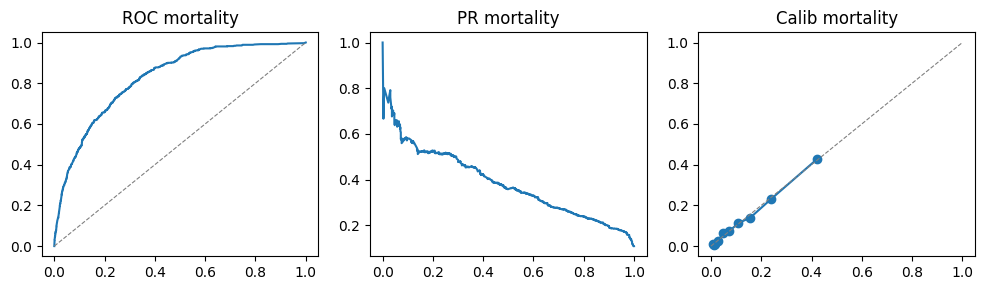

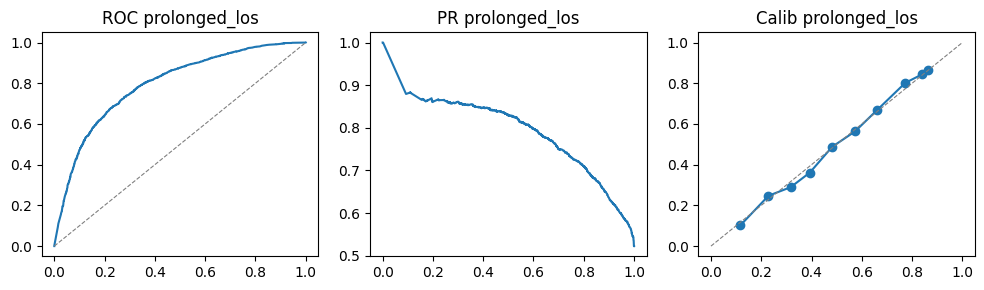

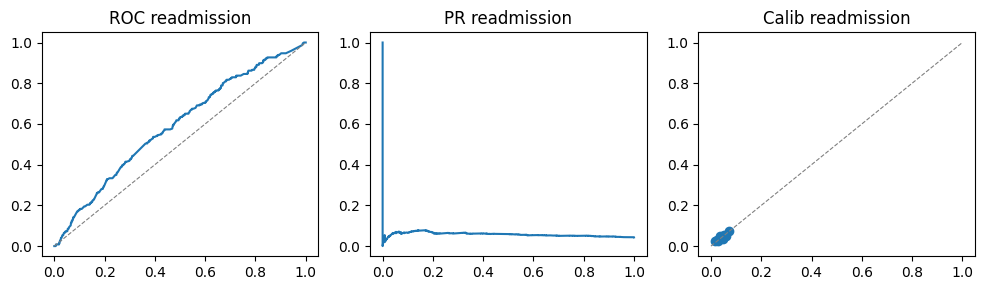

In [14]:
# (Optional) Display calibration & curves if artifacts present in models dir
import json, pandas as pd, os, matplotlib.pyplot as plt
targets = ['mortality','prolonged_los','readmission']
curve_files = {t: os.path.join(MODELS_DIR, f'{t}_curves.json') for t in targets}
plots_shown = False
for t, fp in curve_files.items():
    if os.path.exists(fp):
        with open(fp,'r',encoding='utf-8') as f:
            data = json.load(f)
        try:
            plt.figure(figsize=(10,3))
            plt.subplot(1,3,1)
            plt.plot(data.get('roc_fpr',[]), data.get('roc_tpr',[]))
            plt.plot([0,1],[0,1],'--',color='gray',linewidth=0.8)
            plt.title(f'ROC {t}')
            plt.subplot(1,3,2)
            plt.plot(data.get('pr_recall',[]), data.get('pr_precision',[]))
            plt.title(f'PR {t}')
            plt.subplot(1,3,3)
            calib_p = data.get('calibration_mean_proba',[])
            calib_r = data.get('calibration_empirical_rate',[])
            if calib_p and calib_r:
                plt.plot(calib_p, calib_r, marker='o')
                plt.plot([0,1],[0,1],'--',color='gray',linewidth=0.8)
            plt.title(f'Calib {t}')
            plt.tight_layout()
            plots_shown = True
        except Exception as e:
            print('Plot error for', t, e)
if not plots_shown:
    print('No curve artifacts found or plotting failed.')

### Notes
- Set `LABELS_CSV` if you want metrics; otherwise only predictions are produced.
- Models directory is auto-resolved via `MLHC_MODELS_DIR` env var if set (training notebook sets it).
- Evaluation outputs stored under the evaluation run directory next to models.

### Extended Visual Diagnostics
Additional plots: consolidated metrics table, confusion matrices, ROC/PR overlay, prevalence & calibration detail. Run only after metrics cell above.

In [15]:
# Metrics summary & confusion matrices (requires metrics variable from earlier cell)
import pandas as pd, numpy as np, os, json, matplotlib.pyplot as plt
from itertools import product

if 'metrics' not in globals() or not metrics:
    print('No metrics available (ensure labels were found). Skipping extended diagnostics.')
else:
    rows = []
    for name, m in metrics.items():
        rows.append({
            'task': name,
            'n': m.get('n'),
            'positives': m.get('positives'),
            'prev': m.get('prevalence'),
            'roc_auc': m.get('roc_auc'),
            'pr_auc': m.get('pr_auc'),
            'brier': m.get('brier'),
            'ece': m.get('ece'),
            'threshold': m.get('threshold'),
            'precision': m.get('precision'),
            'recall': m.get('recall'),
            'f1': m.get('f1'),
            'specificity': m.get('specificity'),
            'accuracy': m.get('accuracy'),
        })
    summary_df = pd.DataFrame(rows).set_index('task')
    display(summary_df.round(4))

    # Confusion matrices if cm present
    cm_tasks = [t for t,mv in metrics.items() if mv.get('cm')]
    if cm_tasks:
        fig, axes = plt.subplots(1, len(cm_tasks), figsize=(5*len(cm_tasks),4))
        if len(cm_tasks)==1:
            axes = [axes]
        for ax, task in zip(axes, cm_tasks):
            cm = metrics[task]['cm']
            tp, tn, fp, fn = cm.get('tp'), cm.get('tn'), cm.get('fp'), cm.get('fn')
            # Reconstruct matrix [[tn, fp],[fn,tp]]
            mat = np.array([[tn, fp],[fn, tp]], dtype=float)
            ax.imshow(mat, cmap='Blues')
            for i,j in product(range(2), range(2)):
                ax.text(j, i, int(mat[i,j]), ha='center', va='center', color='black')
            ax.set_xticks([0,1]); ax.set_yticks([0,1])
            ax.set_xticklabels(['Neg','Pos']); ax.set_yticklabels(['Neg','Pos'])
            ax.set_xlabel('Pred'); ax.set_ylabel('True')
            ax.set_title(f'CM: {task}')
        plt.tight_layout()
    else:
        print('No confusion matrices present in metrics (maybe thresholding disabled).')

No metrics available (ensure labels were found). Skipping extended diagnostics.


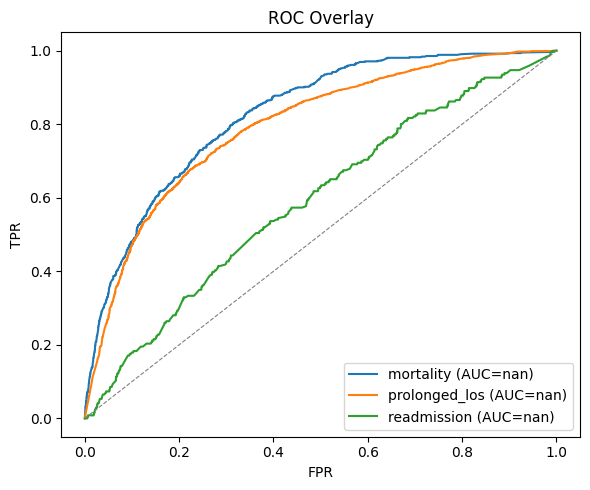

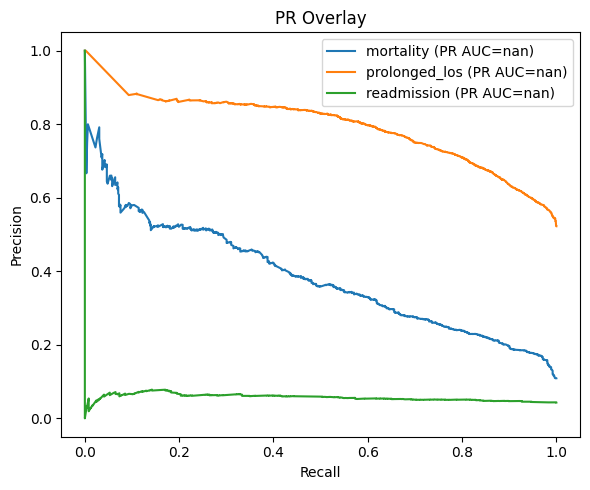

In [16]:
# Combined ROC & PR overlays (reusing curve JSON artifacts)
import json, os, matplotlib.pyplot as plt, numpy as np
curve_tasks = ['mortality','prolonged_los','readmission']
curves = {}
for t in curve_tasks:
    fp = os.path.join(MODELS_DIR, f'{t}_curves.json')
    if os.path.exists(fp):
        try:
            with open(fp,'r',encoding='utf-8') as f: curves[t] = json.load(f)
        except Exception as e:
            print('Failed to load curve file', fp, e)

if curves:
    plt.figure(figsize=(6,5))
    for name,data in curves.items():
        fpr = data.get('roc_fpr',[]); tpr = data.get('roc_tpr',[])
        if fpr and tpr:
            plt.plot(fpr, tpr, label=f'{name} (AUC={data.get("roc_auc",float("nan")):.3f})')
    plt.plot([0,1],[0,1],'--',color='gray',linewidth=0.8)
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Overlay'); plt.legend(); plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6,5))
    for name,data in curves.items():
        r = data.get('pr_recall',[]); p = data.get('pr_precision',[])
        if r and p:
            plt.plot(r, p, label=f'{name} (PR AUC={data.get("pr_auc",float("nan")):.3f})')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR Overlay'); plt.legend(); plt.tight_layout()
    plt.show()
else:
    print('No curve artifacts available for overlays.')

In [17]:
# Detailed calibration: bar (count) + reliability curve per task
import matplotlib.pyplot as plt
if 'metrics' in globals() and metrics:
    for task, m in metrics.items():
        cb = m.get('calibration_bins')
        if not cb:
            continue
        try:
            mean_p = cb.get('mean_proba', [])
            emp = cb.get('empirical_rate', [])
            counts = cb.get('count', [])
            if not mean_p or not emp:
                continue
            fig, ax1 = plt.subplots(figsize=(6,4))
            ax1.bar(mean_p, counts, width=0.04, color='lightgray', alpha=0.7, label='Bin count')
            ax1.set_xlabel('Mean predicted probability')
            ax1.set_ylabel('Count', color='gray')
            ax2 = ax1.twinx()
            ax2.plot(mean_p, emp, marker='o', label='Empirical rate', color='C1')
            ax2.plot([0,1],[0,1],'--',color='gray',linewidth=0.8)
            ax2.set_ylabel('Empirical rate', color='C1')
            ax1.set_title(f'Calibration Detail: {task}')
            fig.tight_layout()
            plt.show()
        except Exception as e:
            print('Calibration plot failed for', task, e)
else:
    print('Metrics not available; skip calibration detail.')

Metrics not available; skip calibration detail.


In [18]:
# Prevalence bar chart + export summary
import pandas as pd, matplotlib.pyplot as plt, os
if 'metrics' in globals() and metrics:
    prev_rows = []
    for name, m in metrics.items():
        prev_rows.append({'task': name, 'prevalence': m.get('prevalence'), 'n': m.get('n')})
    prev_df = pd.DataFrame(prev_rows)
    if not prev_df.empty:
        plt.figure(figsize=(4,3))
        plt.bar(prev_df['task'], prev_df['prevalence'])
        plt.ylabel('Prevalence')
        plt.title('Label Prevalence by Task')
        for i,(task,row) in enumerate(prev_df.set_index('task').iterrows()):
            plt.text(i, row['prevalence']+0.005, f"n={int(row['n'])}", ha='center', fontsize=8)
        plt.ylim(0, max(0.05, prev_df['prevalence'].max()*1.15))
        plt.tight_layout()
        plt.show()
    # Export combined summary if available
    if 'summary_df' in globals():
        out_csv = os.path.join(EVAL_OUT_DIR, 'extended_metrics_summary.csv')
        summary_df.to_csv(out_csv)
        print('Exported extended metrics summary ->', out_csv)
else:
    print('Metrics not available; skipping prevalence and export.')

Metrics not available; skipping prevalence and export.


### Run Comparison (Latest Two Training Runs)
Automatically loads metrics.json from the two most recent run directories under runs/ and produces a delta table plus selected plots. Adjust MAX_RUNS or filter logic as needed.

In [ ]:
# Compare latest two runs' metrics
import os, json, pathlib, pandas as pd, matplotlib.pyplot as plt

RUNS_BASES = []
for base in [pathlib.Path.cwd(), pathlib.Path.cwd().parent]:
    cand = base / 'runs'
    if cand.is_dir():
        RUNS_BASES.append(cand)

run_dirs = []
for rb in RUNS_BASES:
    for d in rb.iterdir():
        if d.is_dir() and (d / 'models' / 'metrics.json').is_file():
            run_dirs.append(d)

if len(run_dirs) < 2:
    print('Fewer than 2 runs with metrics.json found; skipping comparison.')
else:
    # Sort descending by directory name (timestamp) then take top 2
    run_dirs = sorted(run_dirs, key=lambda p: p.name, reverse=True)[:2]
    comp = []
    metrics_by_run = {}
    for rd in run_dirs:
        with open(rd / 'models' / 'metrics.json','r',encoding='utf-8') as f:
            metrics_by_run[rd.name] = json.load(f)
    # Collect metric keys of interest
    core_keys = ['roc_auc','pr_auc','brier','ece','f1','precision','recall','specificity','accuracy','prevalence']
    rows = []
    tasks = sorted({t for m in metrics_by_run.values() for t in m.keys()})
    for task in tasks:
        row = {'task': task}
        for rd in run_dirs:
            m = metrics_by_run[rd.name].get(task, {})
            for k in core_keys:
                row[f'{rd.name}:{k}'] = m.get(k)
        rows.append(row)
    comp_df = pd.DataFrame(rows).set_index('task')
    # Compute deltas: newest - older
    newest, older = run_dirs[0].name, run_dirs[1].name
    delta_cols = {}
    for k in core_keys:
        nk = f'{newest}:{k}'; ok = f'{older}:{k}'
        if nk in comp_df.columns and ok in comp_df.columns:
            comp_df[f'delta_{k}'] = comp_df[nk] - comp_df[ok]
            delta_cols[f'delta_{k}'] = comp_df[f'delta_{k}']
    display(comp_df.round(4))

    # Bar plot for selected metrics deltas
    plot_metrics = ['roc_auc','pr_auc','f1']
    nplot = len(plot_metrics)
    fig, axes = plt.subplots(1, nplot, figsize=(4*nplot,3))
    if nplot == 1:
        axes = [axes]
    for ax, mk in zip(axes, plot_metrics):
        col = f'delta_{mk}'
        if col in comp_df.columns:
            ax.bar(comp_df.index, comp_df[col])
            ax.axhline(0,color='gray',linewidth=0.8)
            ax.set_title(f'Delta {mk}\n({newest} - {older})')
            ax.set_xticklabels(comp_df.index, rotation=30, ha='right')
    plt.tight_layout(); plt.show()

    # Optional: export comparison
    out_csv = run_dirs[0] / 'models' / f'comparison_vs_{older}.csv'
    comp_df.to_csv(out_csv)
    print('Saved comparison CSV ->', out_csv)
